In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import animation as ibl_ani
import numbergen as ng
import imagen as ig
from tqdm import tqdm
import matplotlib.animation as animation
import os
from os.path import join
from evaluation import evaluate, mitsuba_render,net_gt, net_render
import shutil
import imageio 
import cv2
from IPython.display import HTML

def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

In [8]:
def show(img, title=''):
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [72]:
test_folder = 'animation'
os.makedirs(test_folder, exist_ok=True)

animation_list = [join(test_folder, '{:03d}'.format(i)) for i in range(1, 11)]

In [75]:
def to_normalized_ibl(ibl_np):
    """ pattern -> normalized_ibl
    """
    ibl_np = ibl_np * 3500.0
    ibl_np = cv2.resize(ibl_np, (32,16))
    ibl_np[6:,:] = 0.0
    return ibl_np 

def save_ibls(output_folder, num, size, save_ani=False):
    animator = ibl_ani.base_ibl_animator(num, size, verbose=False)
    max_iter = 720 * 2
    
    ims = []
    fig = plt.figure()
    
    for i in tqdm(range(max_iter)):
        ori = animator.animate_ibl(i, max_iter)
        img = to_normalized_ibl(ori)
        fpath = join(output_folder, '{:06d}.png'.format(i))
        plt.axis('off')
        plt.imsave(fpath, img, cmap='gray')
        
        cv2.normalize(ori, ori, 0.0, 1.0, cv2.NORM_MINMAX)
        im = plt.imshow(ori, animated=True, cmap='gray')
        ims.append([im])
    
    if save_ani:
        ani = animation.ArtistAnimation(fig, ims, interval=24, blit=True, repeat_delay=1000)
        ani.save('{}ibl_ani.mp4'.format(num))

def save_uniform_ibls(output_folder, size, num):
    def get_ibl(u,v,size, num):
        gs = ig.Composite(operator=np.add,
                generators=[ig.Gaussian(
                            size=size,
                            scale=1.0,
                            x=(u/512)-0.5,
                            y=(1.0 - v/256)-0.5,
                            aspect_ratio=1.0,
                            ) for i in range(num)],
                    xdensity=512)
        return gs()
    ims = []
    fig = plt.figure()
    
    counter = 0
    for i in tqdm(range(0, 512, 8)):
        for j in range(0,80,2):
            img = to_normalized_ibl(get_ibl(i,j,size, num))
            fpath = join(output_folder, '{:06d}.png'.format(counter))
            plt.axis('off')
            plt.imsave(fpath, img, cmap='gray')
            im = plt.imshow(img, cmap='gray')
            ims.append([im])
            counter += 1
        print('finish')

    print('finish')
    
#     ani = animation.ArtistAnimation(fig, ims, interval=24, blit=True, repeat_delay=1000)
#     ani.save('{}ibl_ani.mp4'.format(num))
#     HTML(ani.to_html5_video())


100%|██████████| 1440/1440 [00:11<00:00, 123.60it/s]

100%|██████████| 1440/1440 [00:17<00:00, 83.54it/s]

100%|██████████| 1440/1440 [00:24<00:00, 58.70it/s]

100%|██████████| 1440/1440 [00:32<00:00, 44.96it/s]

100%|██████████| 1440/1440 [00:36<00:00, 39.06it/s]

100%|██████████| 1440/1440 [00:43<00:00, 33.35it/s]

100%|██████████| 1440/1440 [00:51<00:00, 28.02it/s]

100%|██████████| 1440/1440 [01:00<00:00, 23.88it/s]

100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]

100%|██████████| 1440/1440 [01:11<00:00, 20.21it/s]


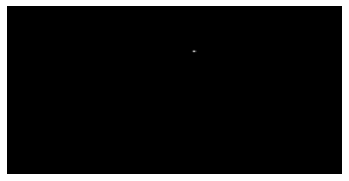

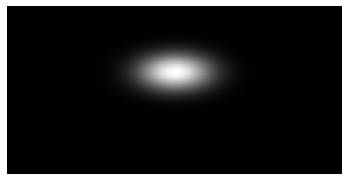

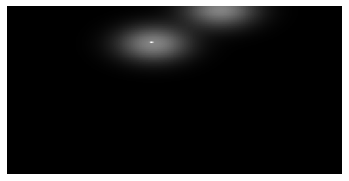

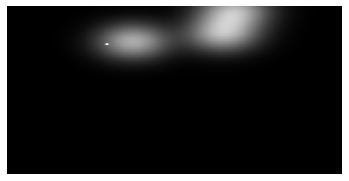

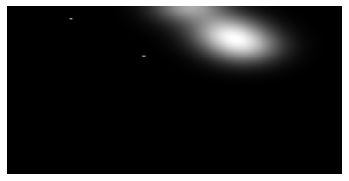

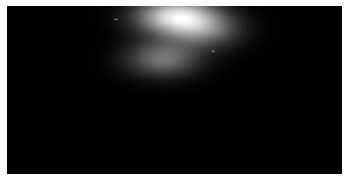

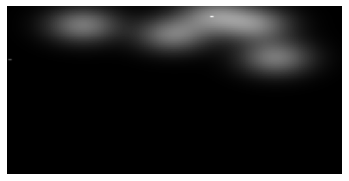

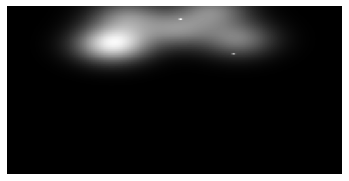

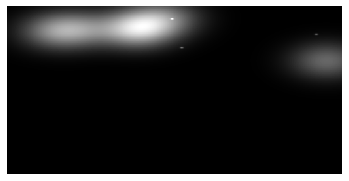

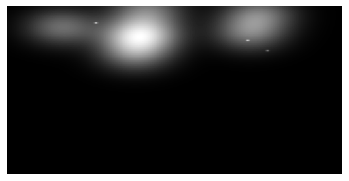

In [76]:
# animation_list = [join(test_folder, '001'), join(test_folder, '002'), join(test_folder, '020')]
# animation_list = [join(test_folder, '001') ]

for folder in animation_list:
    os.makedirs(folder, exist_ok=True)
    folder_name = os.path.basename(folder)
    num = int(folder_name)
    ani = save_ibls(folder, num, 0.01)

## Prepare Mitsuba animation

In [77]:
ibl_animation_folder = 'animation'
animation_folders = get_folders(ibl_animation_folder)
# animation_folders = [join(ibl_animation_folder, '001'), join(ibl_animation_folder, '003'), join(ibl_animation_folder, '020')]
# animation_folders = [join(ibl_animation_folder, '001')]
animation_folders.sort()

#todo
cmd_path = 'mistuba_animation.sh'
if os.path.exists(cmd_path):
    print('update bash')
    os.remove(cmd_path)

# mask_file = '/home/ysheng/Dataset/new_dataset/cache/mask/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/pitch_15_rot_0_mask.png'
mask_file = '/home/ysheng/Dataset/new_dataset/cache/test_mask/simulated_combine_male_genesis8_matias_hywavybob_dsoset_Base_Pose_Walking_B/pitch_30_rot_60_mask.png'
mask_name = os.path.basename(os.path.dirname(mask_file))
ani_out = '/home/ysheng/Dataset/eval_animation'
cur_out = join(ani_out, mask_name)
os.makedirs(cur_out, exist_ok=True)

dbg, dbg_num = False, 1
with tqdm(total=len(animation_folders)) as pbar:
    for cur_ani_folder in animation_folders:
        ibls = [join(cur_ani_folder, f) for f in os.listdir(cur_ani_folder) if f.find('png') != -1]
        print('{} there are {} ibls'.format(cur_ani_folder, len(ibls)))
        ibls.sort()
        
        ibl_name = os.path.basename(cur_ani_folder)
        cur_ani_out_folder = join(cur_out, ibl_name)
        os.makedirs(cur_ani_out_folder, exist_ok=True)
        
        for i, ibl in enumerate(ibls):
            prefix = os.path.splitext(os.path.basename(ibl))[0]
            
            final_out_file, shadow_out_file = join(cur_ani_out_folder, prefix + '_final.exr'), join(cur_ani_out_folder, prefix + '_shadow.exr')
            render_final = False
            if i == 0:
                render_final=True
                
            mitsuba_render(mask_file, ibl, final_out_file, shadow_out_file, update_cam_param=True,real_ibl=False, write_cmd=True, skip=False, cmd_path=cmd_path, final=render_final)
            
        pbar.update()
        if dbg and pbar.n >= dbg_num:
            break


  0%|          | 0/11 [00:00<?, ?it/s]

update bash
animation/.ipynb_checkpoints there are 0 ibls
animation/001 there are 1440 ibls



 18%|█▊        | 2/11 [00:54<04:06, 27.44s/it]

animation/002 there are 1440 ibls



 27%|██▋       | 3/11 [01:50<04:46, 35.76s/it]

animation/003 there are 1440 ibls



 36%|███▋      | 4/11 [02:47<04:56, 42.38s/it]

animation/004 there are 1440 ibls



 45%|████▌     | 5/11 [03:45<04:41, 46.99s/it]

animation/005 there are 1440 ibls



 55%|█████▍    | 6/11 [04:38<04:04, 48.88s/it]

animation/006 there are 1440 ibls



 64%|██████▎   | 7/11 [05:31<03:20, 50.03s/it]

animation/007 there are 1440 ibls



 73%|███████▎  | 8/11 [06:24<02:32, 50.90s/it]

animation/008 there are 1440 ibls



 82%|████████▏ | 9/11 [07:17<01:43, 51.61s/it]

animation/009 there are 1440 ibls



 91%|█████████ | 10/11 [08:09<00:51, 51.70s/it]

animation/010 there are 1440 ibls



100%|██████████| 11/11 [09:01<00:00, 49.27s/it]


## Prepare Net animation

In [78]:
ibl_animation_folder = 'animation'
# animation_folders = get_folders(ibl_animation_folder)
# animation_folders = [join(ibl_animation_folder, '001'), join(ibl_animation_folder, '003'), join(ibl_animation_folder, '020')]
# animation_folders = [join(ibl_animation_folder, '000')]
animation_folders.sort()

dbg, dbg_num = False, 1
with tqdm(total=len(animation_folders)) as pbar:
    for cur_ani_folder in animation_folders:
        ibls = [join(cur_ani_folder, f) for f in os.listdir(cur_ani_folder) if f.find('png') != -1]
        print('{} there are {} ibls'.format(cur_ani_folder, len(ibls)))
        ibls.sort()
        
        ibl_name = os.path.basename(cur_ani_folder)
        cur_ani_out_folder = join(cur_out, ibl_name)
        os.makedirs(cur_ani_out_folder, exist_ok=True)
        
        for i, ibl in enumerate(ibls):
            prefix = os.path.splitext(os.path.basename(ibl))[0]
            out_file = join(cur_ani_out_folder, prefix + '_net.png')
            net_render(mask_file, ibl, out_file, save_npy=True)
            
        pbar.update()
        
        if dbg and pbar.n >= dbg_num:
            break


  0%|          | 0/11 [00:00<?, ?it/s]

animation/.ipynb_checkpoints there are 0 ibls
animation/001 there are 1440 ibls



 18%|█▊        | 2/11 [00:24<01:48, 12.11s/it]

animation/002 there are 1440 ibls



 27%|██▋       | 3/11 [00:48<02:06, 15.77s/it]

animation/003 there are 1440 ibls



 36%|███▋      | 4/11 [01:12<02:08, 18.32s/it]

animation/004 there are 1440 ibls



 45%|████▌     | 5/11 [01:37<02:00, 20.14s/it]

animation/005 there are 1440 ibls



 55%|█████▍    | 6/11 [02:01<01:47, 21.49s/it]

animation/006 there are 1440 ibls



 64%|██████▎   | 7/11 [02:26<01:29, 22.32s/it]

animation/007 there are 1440 ibls



 73%|███████▎  | 8/11 [02:50<01:09, 23.07s/it]

animation/008 there are 1440 ibls



 82%|████████▏ | 9/11 [03:15<00:46, 23.47s/it]

animation/009 there are 1440 ibls



 91%|█████████ | 10/11 [03:39<00:23, 23.76s/it]

animation/010 there are 1440 ibls



100%|██████████| 11/11 [04:04<00:00, 22.23s/it]


In [28]:
def make_animation(out_fname, render_files, ibl_files):
    ims = []
    fig = plt.figure()
    render_files.sort()
    ibl_files.sort()
    
    for i,f in enumerate(tqdm(render_files)):
        plt.axis('off')
        img = plt.imread(f)

        ibl = plt.imread(ibl_files[i])
        w,h = 64, 32
        ibl = np.clip(cv2.resize(ibl, (w, h)), 0.0, 1.0)
        c = img.shape[2]
        img[:h,:w] = ibl[:,:, :c]
        im = plt.imshow(img, animated=True)
        ims.append([im])
        
    ani = animation.ArtistAnimation(fig, ims, interval=24, blit=True, repeat_delay=1000)
    ani.save(out_fname)

dbg = False
search_str = {'mitsuba':'shadow.png', 'net':'net.png'}
def render_animations(render_out_folder, ani_out_folder, typename='mitsuba'):
    models = get_folders(render_out_folder)
    ori_ibl_folder = 'animation/'
    
    with tqdm(total=len(models)) as pbar:
        for model in models:
            ibl_folds = get_folders(model)
            print('{}: {}'.format(model, len(ibl_folds)))

            for ibl in tqdm(ibl_folds):
                model_name, ibl_name = os.path.basename(model), os.path.basename(ibl)
                
                ibl_files = get_files(join(ori_ibl_folder, ibl_name))
                mts_result_files = [join(ibl, f) for f in os.listdir(ibl) if (f.find(search_str['mitsuba']) != -1)]
                net_result_files = [join(ibl, f) for f in os.listdir(ibl) if (f.find(search_str['net']) != -1)]
                mts_out_fname = '{}_{}_mitsuab.mp4'.format(model_name, ibl_name)
                net_out_fname = '{}_{}_net.mp4'.format(model_name, ibl_name)
                
                mts_out_fname = join(ani_out_folder, mts_out_fname)
                net_out_fname = join(ani_out_folder, net_out_fname)
                
                if typename == 'mitsuba':
                    make_animation(mts_out_fname, mts_result_files, ibl_files)
                
                if typename == 'net':
                    make_animation(net_out_fname, net_result_files, ibl_files)
                
                if typename == 'both':
                    make_animation(net_out_fname, net_result_files, ibl_files)
                    make_animation(mts_out_fname, mts_result_files, ibl_files)
                
                if dbg:
                    break
            if dbg:
                break
                
            pbar.update()
            

## Render Mitsuba and Net Animations 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

  3%|▎         | 20/720 [00:00<00:03, 189.00it/s]

/home/ysheng/Dataset/eval_animation/simulated_combine_male_genesis8_matias_hywavybob_dsoset_Base_Pose_Walking_B: 1




  7%|▋         | 49/720 [00:00<00:03, 210.61it/s]

 11%|█         | 79/720 [00:00<00:02, 229.46it/s]

 15%|█▍        | 106/720 [00:00<00:02, 239.99it/s]

 18%|█▊        | 127/720 [00:00<00:03, 166.71it/s]

 22%|██▏       | 157/720 [00:00<00:02, 191.76it/s]

 26%|██▌       | 187/720 [00:00<00:02, 214.03it/s]

 30%|███       | 216/720 [00:00<00:02, 231.40it/s]

 34%|███▍      | 245/720 [00:01<00:01, 245.97it/s]

 38%|███▊      | 275/720 [00:01<00:01, 259.92it/s]

 42%|████▏     | 303/720 [00:01<00:01, 265.49it/s]

 46%|████▌     | 331/720 [00:01<00:01, 267.46it/s]

 50%|█████     | 361/720 [00:01<00:01, 275.37it/s]

 54%|█████▍    | 390/720 [00:01<00:01, 278.61it/s]

 58%|█████▊    | 420/720 [00:01<00:01, 283.13it/s]

 63%|██████▎   | 451/720 [00:01<00:00, 288.06it/s]

 67%|██████▋   | 482/720 [00:01<00:00, 292.26it/s]

 71%|███████   | 512/720 [00:01<00:00, 293.29it/s]

 75%|███████▌  | 542/720 [00:02<00:00, 289.99it/s]

 79%|███████▉  | 572/720 [00:02<00:00, 291.56it/s]

 84%|███████

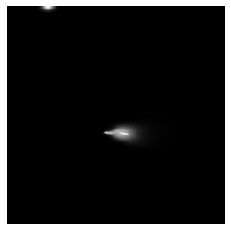

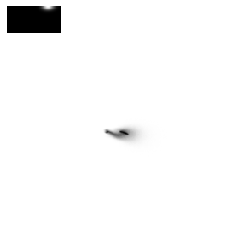

In [30]:
rendering_out_folder = '/home/ysheng/Dataset/eval_animation/'
animation_out = 'ani_out'
os.makedirs(animation_out, exist_ok=True)

render_animations(rendering_out_folder, animation_out, 'both')
# render_animations(rendering_out_folder, animation_out, 'mitsuba')
# render_animations(rendering_out_folder, animation_out, 'both')

## Test for Mitsuba Rendering

shape: (16, 32, 4) min: 0, max: 255


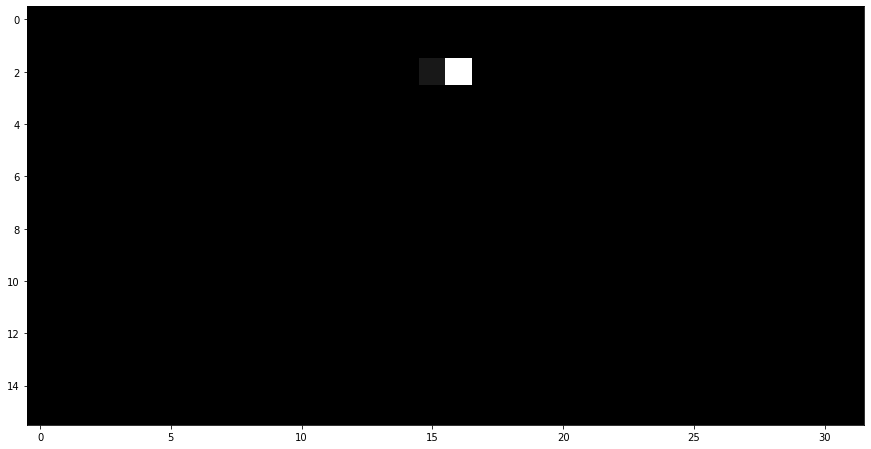

min: 5.826450433232822e-13, max: 1.0
min: -5.165929906070232e-10, max: 1.0


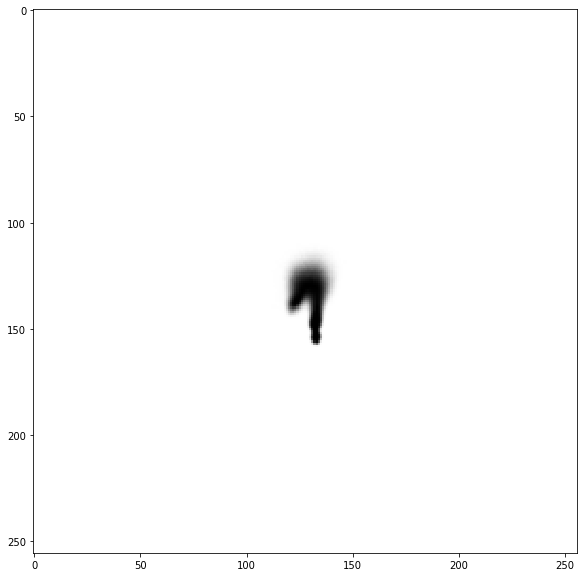

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


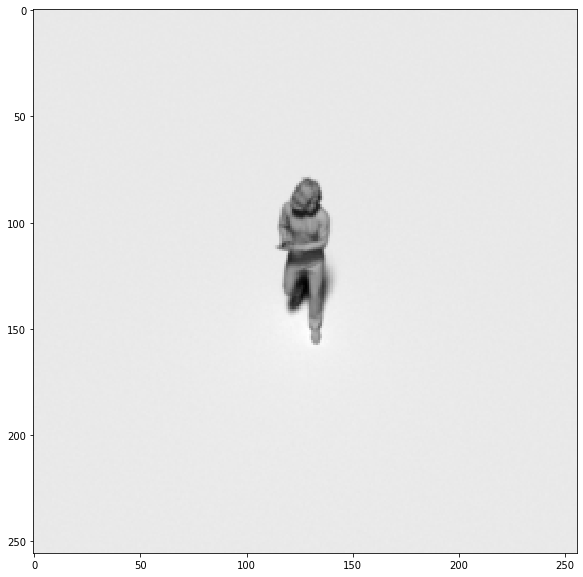

In [31]:
folder = '/home/ysheng/Dataset/eval_animation/simulated_combine_male_genesis8_matias_hywavybob_dsoset_Base_Pose_Walking_B/001'
test_shadow, test_final = join(folder, '000000_shadow.exr'), join(folder, '000000_final.exr')
ibl_file = 'animation/001/000000.png'
ibl = imageio.imread(ibl_file)
print('shape: {} min: {}, max: {}'.format(ibl.shape, np.min(ibl), np.max(ibl)))
show(ibl)

test_shadow_np, test_final_np = imageio.imread(test_shadow), imageio.imread(test_final)

cv2.normalize(test_shadow_np, test_shadow_np, 0.0, 1.0, cv2.NORM_MINMAX)
cv2.normalize(test_final_np, test_final_np, 0.0, 1.0, cv2.NORM_MINMAX)

print('min: {}, max: {}'.format(np.min(test_shadow_np), np.max(test_shadow_np)))
print('min: {}, max: {}'.format(np.min(test_final_np), np.max(test_final_np)))
show(test_shadow_np)
show(test_final_np)

min: 0.0, max: 1.0


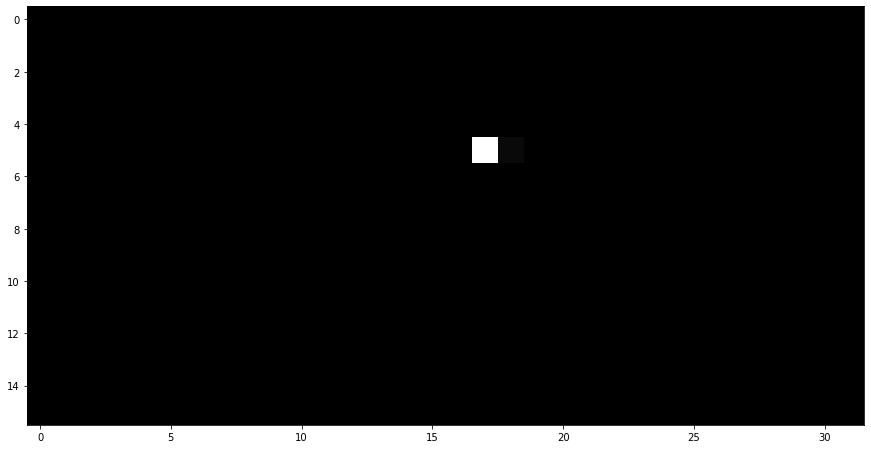

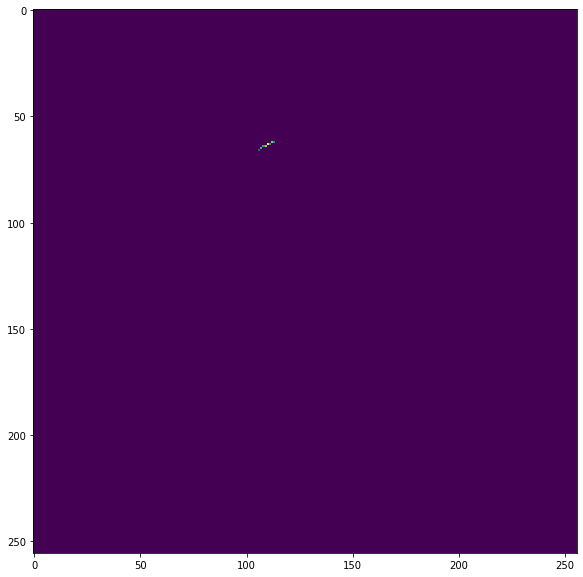

In [36]:
test_ibl_file = 'animation/001/000020.png'
mask_file = '/home/ysheng/Dataset/new_dataset/cache/test_mask/simulated_combine_male_genesis8_matias_hywavybob_dsoset_Base_Pose_Walking_B/pitch_30_rot_60_mask.png'
out_file = 'test.png'
import evaluation
pred = evaluation.net_render(mask_file, test_ibl_file, out_file, save_npy=True)

ibl_np = plt.imread(test_ibl_file)
print('min: {}, max: {}'.format(np.min(ibl_np), np.max(ibl_np)))
show(ibl_np)
show(pred)